https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/model_selection/_split.py

In [71]:
import os
import torch
import pandas as pd
import dask.dataframe as dd
from torch import nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
import numpy as np

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

class SimpleConvNet(nn.Module):
  '''
    Simple Convolutional Neural Network
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(302, 50),
      nn.ReLU(),
      nn.Linear(50, 20),
      nn.ReLU(),
      nn.Linear(20, 10),
      nn.ReLU(),
      nn.Linear(10,2)
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)
  
#인터프리터에서 직접 실행시켰을 때에만 아래 if문을 돌려라.
if __name__ == '__main__':
  
  # Configuration options
  k_folds = 10
  num_epochs = 1
  loss_function = nn.CrossEntropyLoss()
  
  # For fold results
  results = {}
  """
  """
  # Set fixed random number seed
  torch.manual_seed(42)



  gen_temp = pd.read_csv('data\Genetic_alterations.csv')
  time_temp = pd.read_csv('data\Survival_time_event.csv')
  treat_temp = pd.read_csv('data\Treatment.csv')

  #data_concat=gen_temp+time_temp+treat_temp
  #print(np.shape(data_concat))
  
  
  data_genetic=gen_temp.drop(gen_temp.columns[0],axis=1)
  data_time=time_temp.drop(time_temp.columns[0],axis=1)
  data_treat=treat_temp.drop(treat_temp.columns[0],axis=1)

  data_cc=pd.concat([data_genetic, data_time, data_treat], axis=1)
  dataset=[]
  print(np.shape(data_cc.iloc[:,0:302].values.tolist()))
  print(dataset.append(data_cc.iloc[:,0:302].values))
  dataset.append(data_cc.iloc[:,302:].values)
  print(len(dataset))
  dataset=torch.tensor(dataset)
  
  #data_x=torch.tensor(data_cc.iloc[:,0:302].values)
  #data_y=torch.tensor(data_cc.iloc[:,302:].values)

  #dataset=np.concatenate([data_x,data_y], axis=-1)
  #print(np.shape(dataset))
  """
  dataset=[]
  dataset.append(data_x)
  print(dataset)
  dataset.append(data_y)

  #dataset=torch.tensor([data_x,data_y])
  print(len(dataset))
    
 
  # Prepare MNIST dataset by concatenating Train/Test part; we split later.
  dataset_cc = dataset_genetic.to_numpy(), dataset_time.to_numpy(), dataset_treat.to_numpy()
  print(np.shape(dataset_cc))
  #dataset_cc = dataset_cc +  #(1000,303)
    
  #Slicing
  dataset=list()
  dataset.append(dataset_cc.iloc[:,0:301].values)
  dataset.append(dataset_cc.iloc[:,302:].values)
  print(dataset_cc)
  """

(1000, 302)
None
2


ValueError: expected sequence of length 302 at dim 2 (got 1)

#### print(np.shape(dataset_cc)) ==> (1000, 303)

In [47]:
  # Define the K-fold Cross Validator
  kfold = KFold(n_splits=k_folds, shuffle=True) #k_folds = 10, make Kfold class
    
  # Start print
  print('--------------------------------')
"""
     Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for t"hat split.
        이 때, yield: return과 비슷하지만 generator를 출력한다는 점에서 다르다.
"""
  # K-fold Cross Validation model evaluation // train_ids, test_ids : 각 데이터의 인덱스 의미한다.
    #enumerate 결과로 인해서, kfold.split function에 의해 인덱스가 출력되고 해당 인덱스들에 fold라는 번호가 매겨진다.
  for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
# indicis 출력받아서 for문으로 돌린다.
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    print("shape of train_ids in each fold: ", np.shape(train_ids)) #56000개 = 70000/5 * 4
    print("shape of test_ids in each fold: ", np.shape(test_ids)) #14000게 = 70000/5 * 1
    
    # Sample elements randomly from a given list of ids, no replacement. (한 번 뽑은건 돌려놓지 않음)
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    #위 두 변수의 type : <class 'torch.utils.data.sampler.SubsetRandomSampler'>
#Dataset 은 샘플과 정답(label)을 저장하고,
#DataLoader 는 Dataset 을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감쌉니다.
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=3, sampler=train_subsampler) #mini batch 수는 5600개
    testloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=3, sampler=test_subsampler) #mini batch 수는 1400개
    
    # Init the neural network
    network = SimpleConvNet()
    network.apply(reset_weights)
    
    # Initialize optimizer
    optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)
    
    #▶TRAINING◀
    # Run the training loop for defined number of epochs
    for epoch in range(0, num_epochs):

      # Print epoch
      print(f'Starting epoch {epoch+1}')

      # Set current loss value
      current_loss = 0.0

      # Iterate over the DataLoader for training data
      for i, data in enumerate(trainloader, 0):
        
        # Get inputs
        inputs, targets = data
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Perform forward pass
        outputs = network(inputs)
        
        # Compute loss
        loss = loss_function(outputs, targets)
        
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
        
        # Print statistics
        current_loss += loss.item()
        if i % 500 == 499:
            print('Loss after mini-batch %5d: %.3f' %
                  (i + 1, current_loss / 500))
            current_loss = 0.0
            
    # Process is complete.
    print('Training process has finished. Saving trained model.')

    # Print about testing
    print('Starting testing')
    
    # Saving the model
    save_path = f'./model-fold-{fold}.pth'
    torch.save(network.state_dict(), save_path)

    #▶TEST (EVALUATION)◀
    # Evaluationfor this fold USING TEST FOLD!!!!!
    correct, total = 0, 0
    with torch.no_grad():

      # Iterate over the test data and generate predictions
      for i, data in enumerate(testloader, 0):

        # Get inputs
        inputs, targets = data

        # Generate outputs
        outputs = network(inputs)

        # Set total and correct
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

      # Print accuracy
      print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
      print('--------------------------------')
      results[fold] = 100.0 * (correct / total)
    
  # Print fold results
  print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
  print('--------------------------------')
  sum = 0.0
  for key, value in results.items():
    print(f'Fold {key}: {value} %')
    sum += value
  print(f'Average: {sum/len(results.items())} %')

--------------------------------


ValueError: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=2.

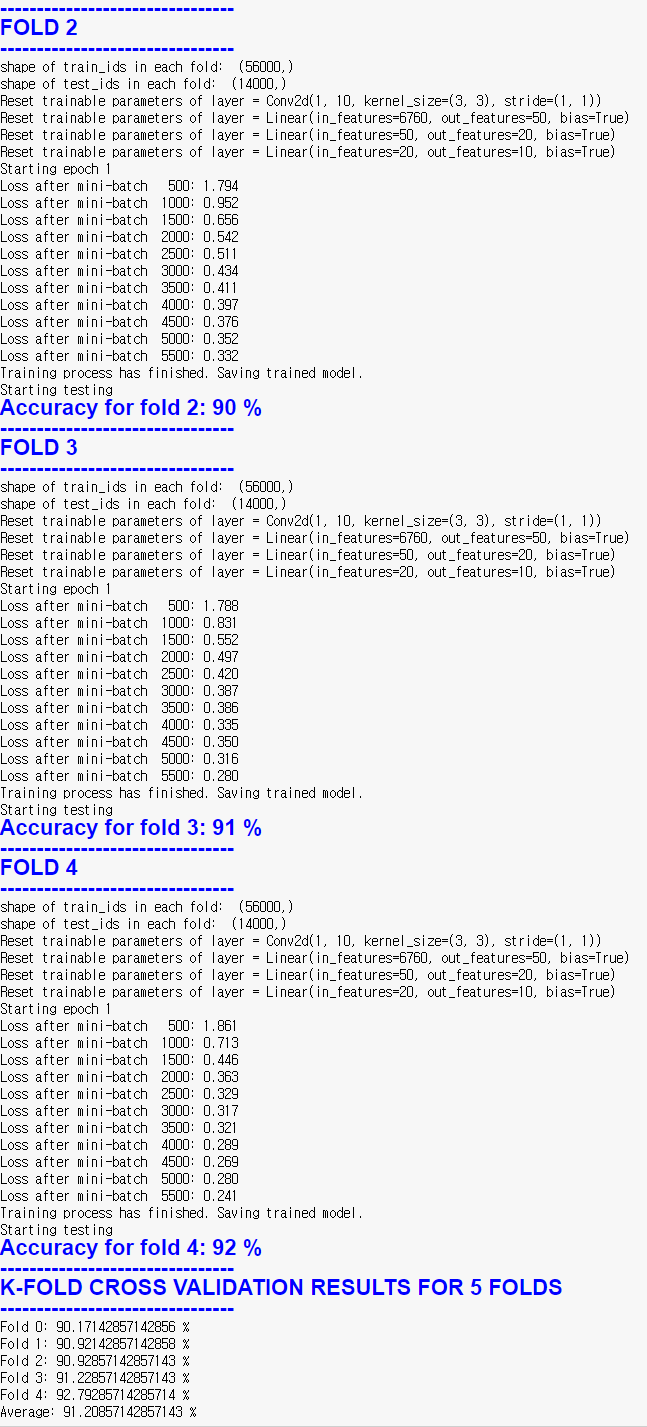